In [18]:

import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Environment Ready")

Environment Ready


In [43]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

Wd = 1024
Hd = 768
Wc = 1280
Hc = 720

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

config.enable_stream(rs.stream.depth, Wd, Hd, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, Wc, Hc, rs.format.bgr8, 30)
    print(f"Using LiDAR camera configuration")
else:
    config.enable_stream(rs.stream.color, W, H, rs.format.bgr8, 30)

# Start streaming
profile=pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()
#motion_range = depth_sensor.get_option(rs.option.motion_range)
print(f"Depth Sensor units in m are {depth_sensor.get_option(rs.option.depth_units)}")
#val = 0
#depth_sensor.set_option(rs.option.motion_range, val)
aligned_stream = rs.align(rs.stream.color) # alignment between color and depth
point_cloud = rs.pointcloud()

Using LiDAR camera configuration
Depth Sensor units in m are 0.0002500000118743628


In [44]:
while True:
        # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    frames = aligned_stream.process(frames)
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    points = point_cloud.calculate(depth_frame)
    if not depth_frame or not color_frame:
        continue
    else:
        pipeline.stop()
        print("Frames Captured")
        break        

Frames Captured


In [45]:
color_img = np.asanyarray(color_frame.get_data())[:,:,::-1]
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
print(f"{color_img.shape}")
print(f"{colorized_depth.shape}")
H,W,C=color_img.shape

(720, 1280, 3)
(720, 1280, 3)


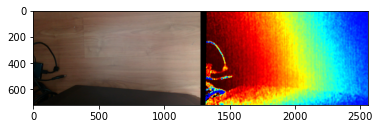

In [46]:
images = np.hstack((color_img, colorized_depth))
plt.imshow(images)

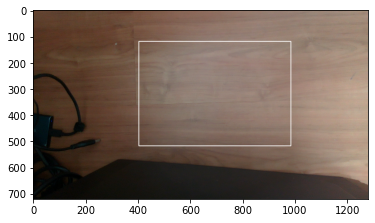

In [47]:
bbox = (int(404), int(119), int(985-404), int(514-116))
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
vis=color_img.copy()
cv2.rectangle(vis, p1, p2, (255, 255, 255), 2)
#cv2.line(vis, (404,116), (985,514), (255, 255, 255), 2)
plt.imshow(vis)

In [48]:
verts = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, W, 3)
obj_points = verts[int(bbox[1]):int(bbox[1] + bbox[3]), int(bbox[0]):int(bbox[0] + bbox[2])].reshape(-1, 3)
print(verts.shape)
xs = obj_points[:, 0]
ys = obj_points[:, 1]
zs = obj_points[:, 2]

(720, 1280, 3)


In [37]:
print(ys.shape)
my = np.min(ys)
My = np.max(ys)
length = (My - my)
mx = np.min(xs)
Mx = np.max(xs)
width = (Mx - mx)
mz = np.min(zs)
Mz = np.max(zs)
depth = (Mz - mz)
print(f"Length is {length*100}cm, Width is {width*100}cm, Depth is {depth*100}cm")

(231238,)
Length is 18.19222718477249cm, Width is 25.014975666999817cm, Depth is 42.60000288486481cm


In [49]:
z = np.median(zs)
mz = np.min(zs)
Mz = np.max(zs)
print(mz)
print(Mz)
print(z)
ys = np.delete(ys, np.where((zs < z - 0.01) | (zs > z + 0.01)))  # take only y for close z to prevent including background
xs = np.delete(xs, np.where((zs < z - 0.01) | (zs > z + 0.01))) 
mx = np.min(xs)
Mx = np.max(xs)
length = (Mx - mx)

my = np.min(ys)
My = np.max(ys)
width = (My - my)

print(f"Length is {length*100}cm, Width is {width*100}cm, Depth is {depth*100}cm")

0.39925003
0.42675003
0.41300002
Length is 26.544401049613953cm, Width is 18.553580343723297cm, Depth is 42.60000288486481cm


In [50]:
#initial_depth=z
d=np.abs(initial_depth-z)

In [52]:
d*100

4.624998569488525